In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
import logging
logging.getLogger('tensorflow').disabled = True

In [3]:
df = pd.read_csv('dataset/london_weather.csv')
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [5]:
selected_columns = ['date', 'mean_temp']
df = df[selected_columns]
df.head()

,date,mean_temp
0,19790101,-4.1
1,19790102,-2.6
2,19790103,-2.8
3,19790104,-2.6
4,19790105,-0.8


In [6]:
df.dropna(subset= selected_columns, inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15305 entries, 0 to 15340
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15305 non-null  datetime64[ns]
 1   mean_temp  15305 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 358.7 KB


In [7]:
min_max_scaler = MinMaxScaler()
mean_reshaped = df['mean_temp'].values.reshape(-1, 1)
df['mean_temp'] = min_max_scaler.fit_transform(mean_reshaped)
df.head()

,date,mean_temp
0,1979-01-01,0.095628
1,1979-01-02,0.136612
2,1979-01-03,0.131148
3,1979-01-04,0.136612
4,1979-01-05,0.185792


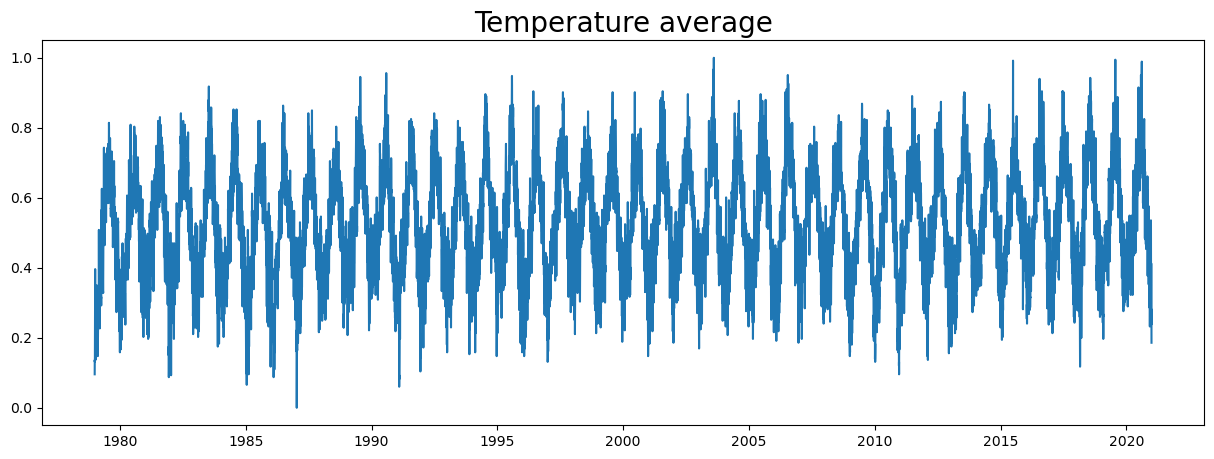

In [8]:
dates = df['date'].values
temp  = df['mean_temp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',fontsize=20);

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
temp_train, temp_test = train_test_split(temp, test_size=0.2, shuffle=False)
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [11]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        mae = logs.get('mae')
        if mae < (df['mean_temp'].max() - df['mean_temp'].min()) * 10/100:
            self.model.stop_training = True
callbacks = MyCallback()

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=test_set, epochs=100, verbose=1, callbacks=[callbacks])
print("MAE telah mencapai < 10%! skala data")

Epoch 1/100
122/122 [==============================] - 21s 123ms/step - loss: 0.0169 - mae: 0.1411 - accuracy: 1.6005e-04 - val_loss: 0.0095 - val_mae: 0.1127 - val_accuracy: 0.0000e+00
Epoch 2/100
122/122 [==============================] - 14s 108ms/step - loss: 0.0090 - mae: 0.1089 - accuracy: 1.5868e-04 - val_loss: 0.0084 - val_mae: 0.1048 - val_accuracy: 0.0000e+00
Epoch 3/100
122/122 [==============================] - 14s 113ms/step - loss: 0.0081 - mae: 0.1019 - accuracy: 1.5868e-04 - val_loss: 0.0076 - val_mae: 0.0986 - val_accuracy: 0.0000e+00
Epoch 4/100
122/122 [==============================] - 15s 118ms/step - loss: 0.0075 - mae: 0.0971 - accuracy: 1.6141e-04 - val_loss: 0.0071 - val_mae: 0.0948 - val_accuracy: 0.0000e+00
MAE telah mencapai < 10%! skala data


In [12]:
print(f"Data Scale     : {df['mean_temp'].max() - df['mean_temp'].min()}")
print(f"10% Data Scale : {(df['mean_temp'].max() - df['mean_temp'].min()) * 10/100}")

Data Scale     : 1.0
10% Data Scale : 0.1


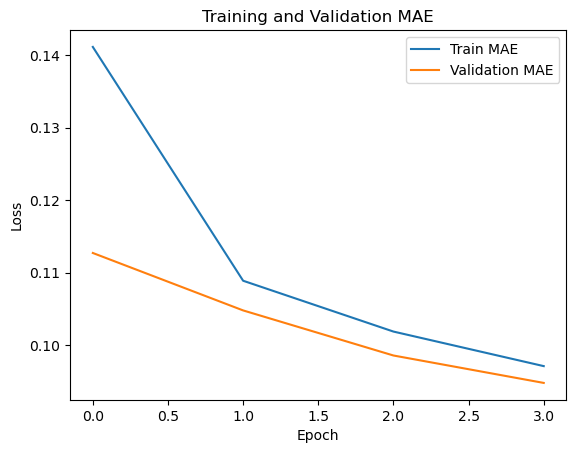

In [13]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

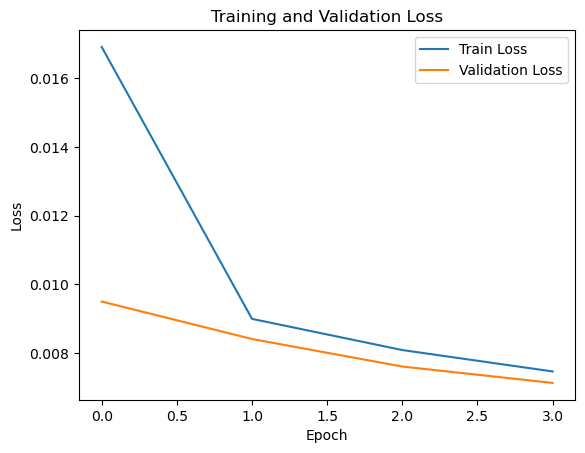

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

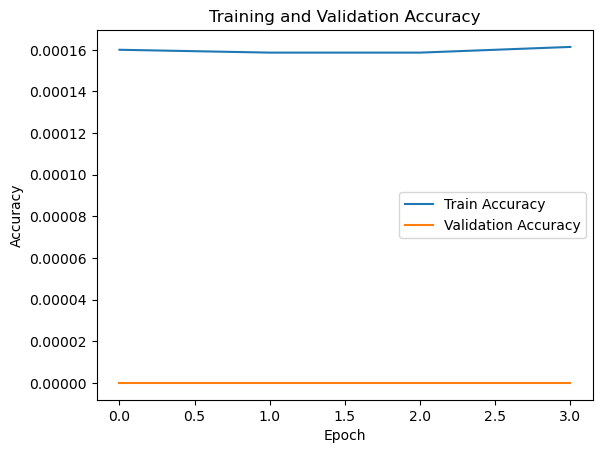

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()